<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_VAR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘progressr’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [ ]:
# 該当リポジトリを変数に格納
c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" ) -> repo
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/population_jp_year.csv" )) -> popURL

# ライブラリの読み込み
library( readr )
library( fable )
library( dplyr )

# ネット上のファイル読み込み
popURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) |>
  mutate( Dr = Death / Total ) -> pop_tsibble

Loading required package: fabletools

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 手順２　データの可視化

まず、データをプロットしてみます。

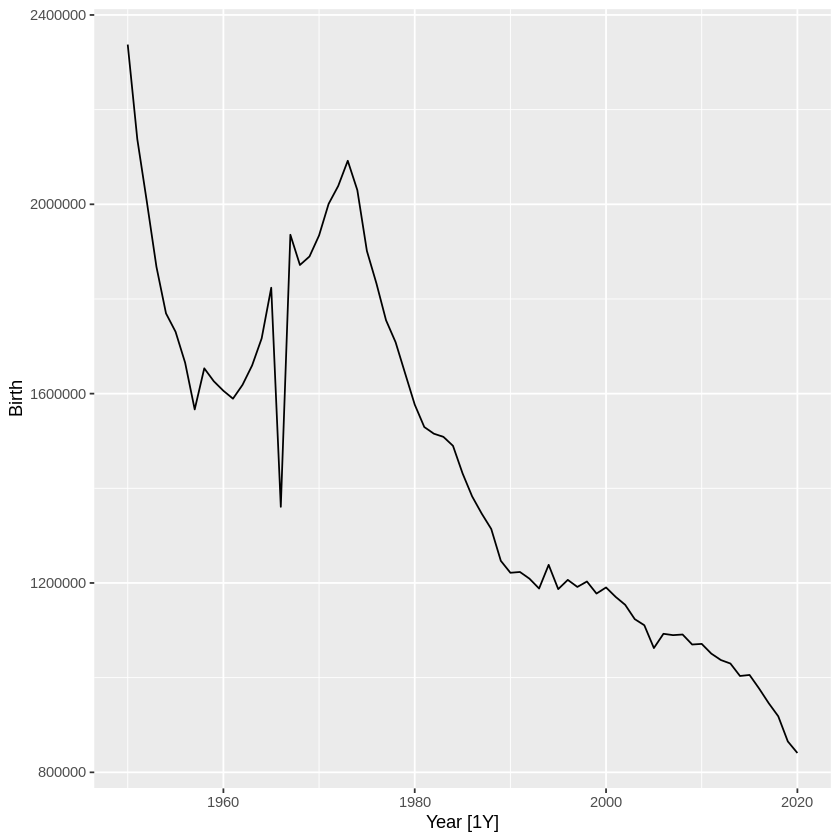

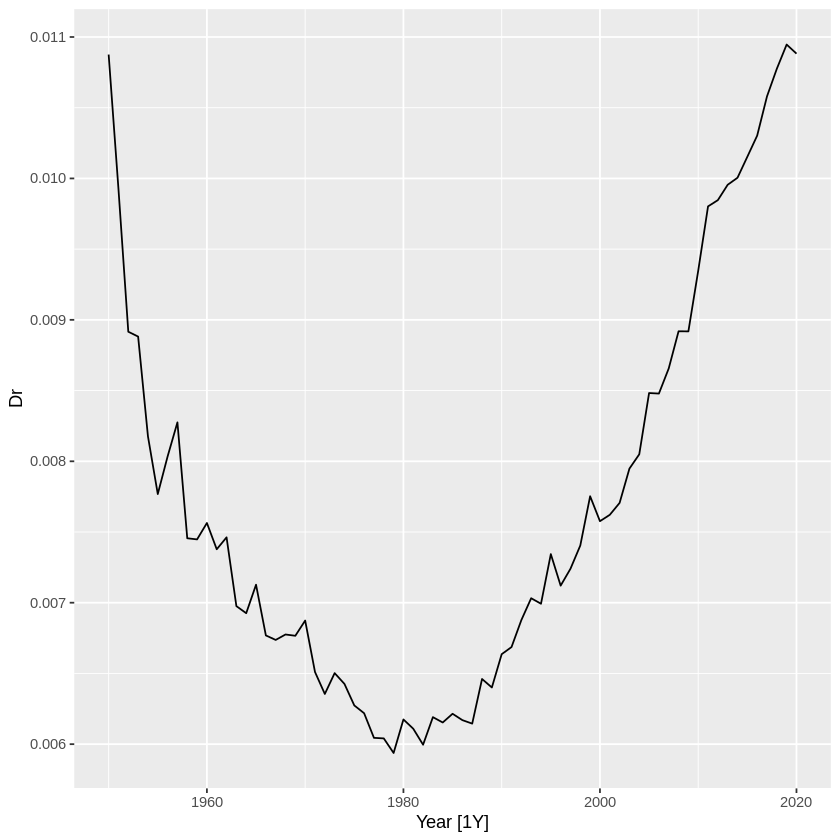

In [ ]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡率のグラフ
pop_tsibble |>
  autoplot( Birth )
pop_tsibble |>
  autoplot( Dr )

次に、自己相関を確認してみます。

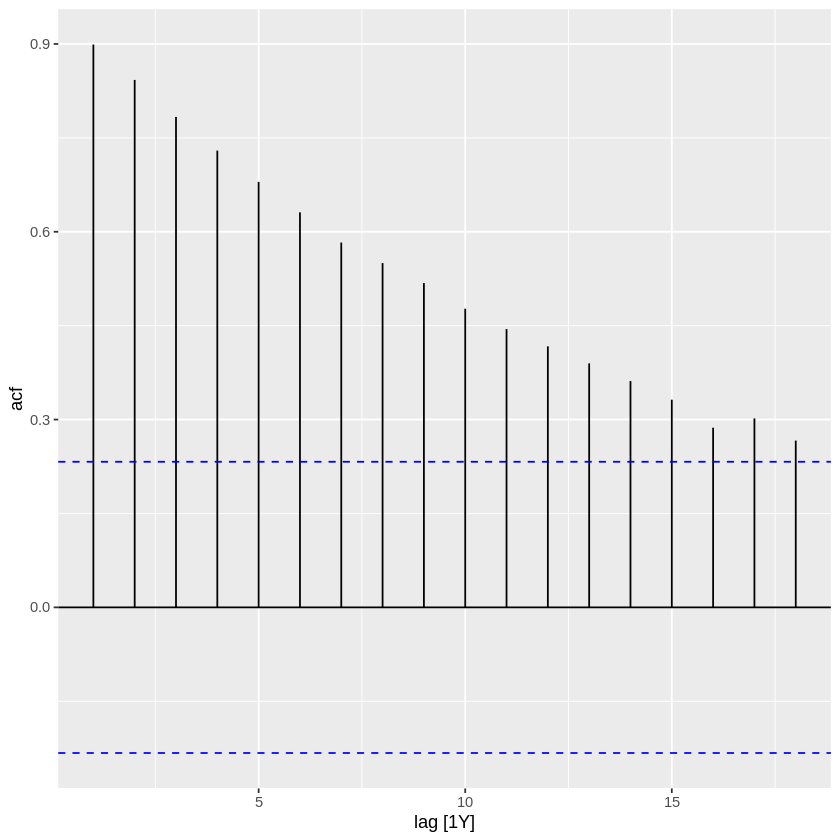

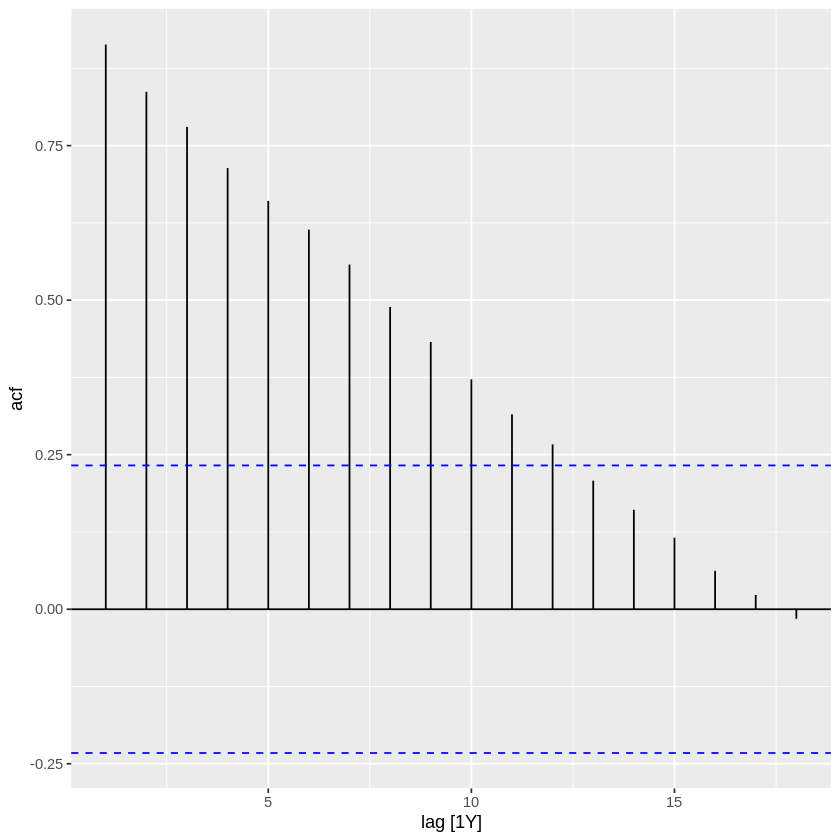

In [ ]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble |>
  ACF( Dr ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

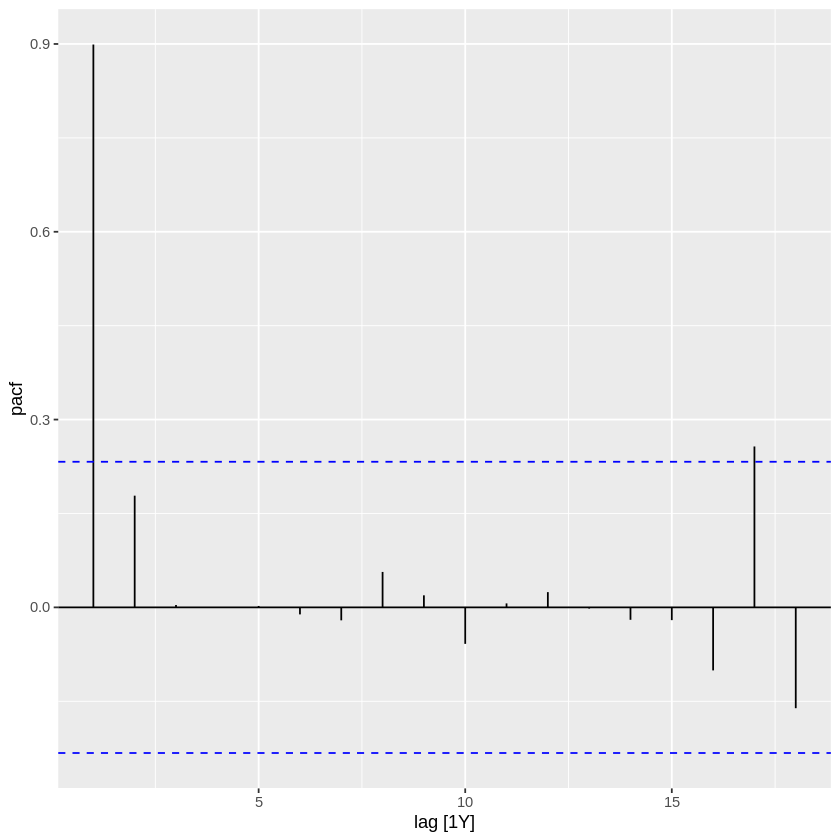

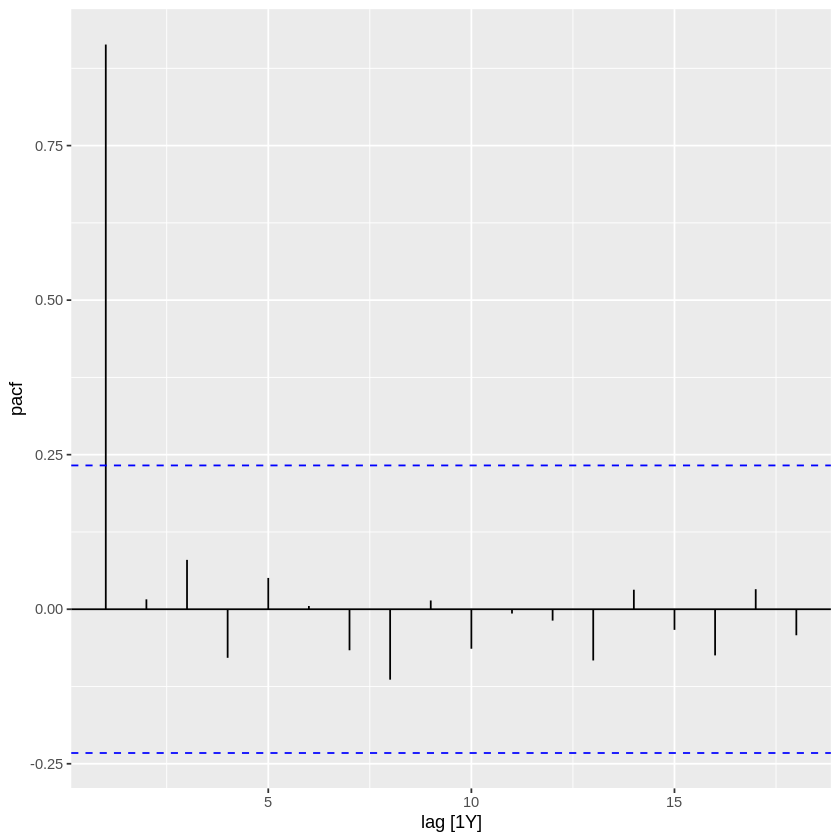

In [ ]:
# 偏自己相関のグラフ
pop_tsibble |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble |>
  PACF( Dr ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
6 -> prow_test2
pop_tsibble |> nrow() - prow_test2 -> prow_train2
pop_tsibble |> tail( n = prow_test2 ) -> pop_test2
pop_tsibble |> head( n = prow_train2 ) -> pop_train2

# 手順４　ＶＡＲモデルによる予測

まず、学習データを使ってＶＡＲモデルを推定します。

In [ ]:
# ＶＡＲモデルの推定
pop_train2 |>
  model( var = VAR( Birth,
                    lag.max = 10,                    
                    ic = "aic",
                    stepwise = FALSE )) -> pop_varB
pop_train2 |>
  model( var = VAR( Dr,
                    lag.max = 10,                    
                    ic = "aic",
                    stepwise = FALSE )) -> pop_varDr
  pop_varB
  pop_varDr

var
<model>
<VAR(5)>


var
<model>
<VAR(1) w/ mean>


出生数ではＶＡＲ（５）が、  
死亡率ではＶＡＲ（１）が推定されたので、予測してみます。

In [ ]:
# ＶＡＲによる予測
pop_varB |>
  forecast( h = "6 years") -> pop_varB_f
pop_varDr |>
  forecast( h = "6 years") -> pop_varDr_f
pop_varB_f
pop_varDr_f

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
var,2015,"N(1e+06, 8.7e+09)",1001185.9
var,2016,"N(989332, 1.1e+10)",989331.9
var,2017,"N(979222, 1.6e+10)",979222.0
var,2018,"N(970318, 2.2e+10)",970317.7
var,2019,"N(963375, 2.8e+10)",963374.9
var,2020,"N(953997, 3.4e+10)",953996.6


.model,Year,Dr,.mean
<chr>,<dbl>,<dist>,<dbl>
var,2015,"N(0.0098, 8.5e-08)",0.009829215
var,2016,"N(0.0097, 1.6e-07)",0.009664403
var,2017,"N(0.0095, 2.2e-07)",0.009509864
var,2018,"N(0.0094, 2.8e-07)",0.009364959
var,2019,"N(0.0092, 3.3e-07)",0.009229087
var,2020,"N(0.0091, 3.8e-07)",0.009101683


# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [ ]:
# 出生数、死亡数の合算
pop_test2 |> rename( "forecast_BD" = Total ) -> pop_var_f3

pop_varB_f |>
  as.data.frame() |>
  select( .mean ) -> pop_var_f3[ ,3 ]
pop_varDr_f |>
  as.data.frame() |>
  select( "Dr" = .mean ) -> pop_var_f3[ ,11 ]
pop_var_f3 |>
  mutate( Death = forecast_BD * Dr,
          forecast_BD = lag( forecast_BD + Birth - Death )) -> pop_var_f3

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126846942,126838000,126864000,126912000,126938000
2017,126706000,126695600,126532000,126605000,126704000,126777000
2018,126443000,126480265,126177000,126315000,126441000,126580000
2019,126167000,126229184,125773000,125998000,126125000,126351000
2020,126146000,125965969,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`


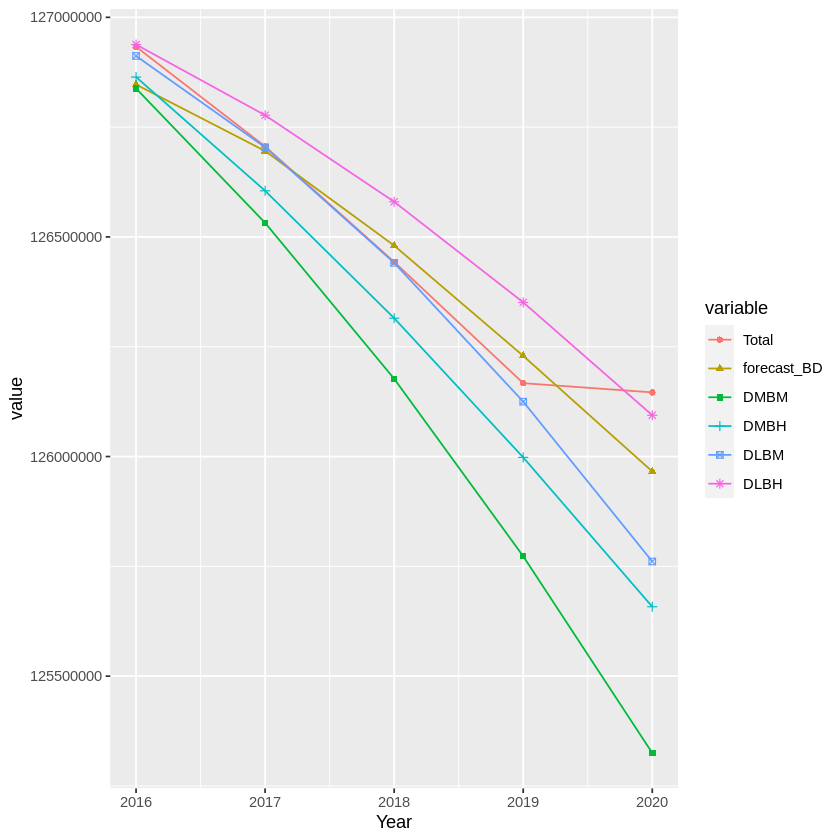

Plot variable not specified, automatically selected `.vars = Dr`


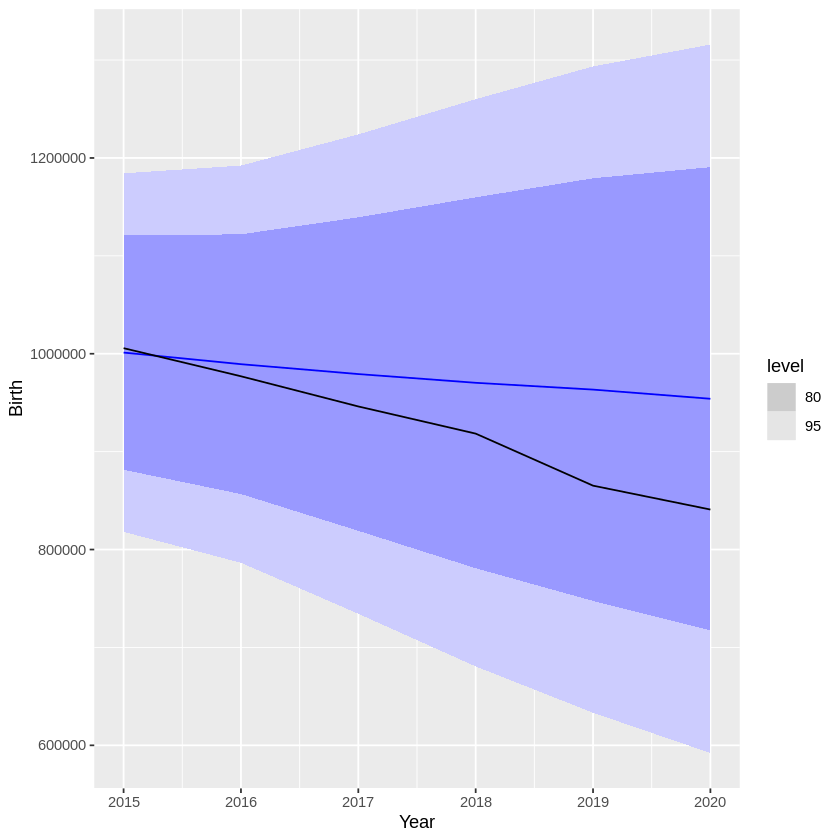

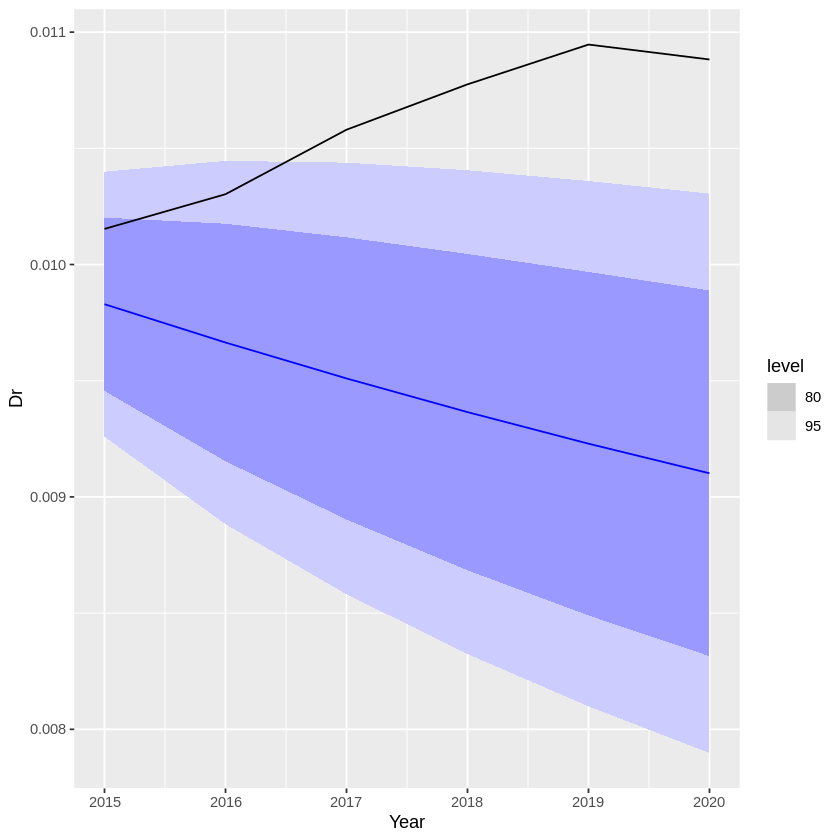

In [ ]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# ネット上のファイル読み込み
ipssURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> ipss_test

pop_var_f3[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) -> join_test2
join_test2

# ライブラリの読み込み
library( reshape2 )

join_test2 |> 
  melt(id="Year",measure=c( "Total",
                            "forecast_BD",
                            "DMBM",
                            "DMBH",
                            "DLBM",
                            "DLBH")) -> join_plot2

#描画
ggplot( join_plot2,
        aes(x = Year,
            y = value,
            shape = variable,
            colour = variable,
            group = variable )) +
  geom_line() +
  geom_point()

  pop_test2 |>
  select( Year, Birth ) -> pop_testB
pop_varB_f |>
  autoplot() +
  autolayer( pop_testB )

pop_test2 |>
  select( Year, Dr ) -> pop_testDr
pop_varDr_f |>
  autoplot() +
  autolayer( pop_testDr )

かなり実測値に近づいてきましたが、
実は、死亡率をかなり低めに予想していて、「結果オーライ」の状態です。 

# 次のステップ


*   同じ事をPythonでやってみる。　->　こちら
*   同じ事をＧＡＲＣＨモデルでやってみる。　->　こちら
*   人口３区分の死亡率を使って推計する　->　[ R_VAR_4 ](https://colab.research.google.com/drive/1rrjM2YXujCp3DEdQtlVWUIHkQ5T1W73A?usp=sharing) 
